In [1]:
import csv
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint


import nltk


print(tf.__version__)

2.12.0


In [2]:
def lempel_ziv_complexity(binary_sequence):
    """Lempel-Ziv complexity for a binary sequence, in simple Python code."""
    u, v, w = 0, 1, 1
    v_max = 1
    length = len(binary_sequence)
    complexity = 1
    while True:
        if binary_sequence[u + v - 1] == binary_sequence[w + v - 1]:
            v += 1
            if w + v >= length:
                complexity += 1
                break
        else:
            if v > v_max:
                v_max = v
            u += 1
            if u == w:
                complexity += 1
                w += v_max
                if w > length:
                    break
                else:
                    u = 0
                    v = 1
                    v_max = 1
            else:
                v = 1
    return complexity


In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

vocab_size = 5000 
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '' #OOV = Out of Vocabulary
training_portion = .8

articles = []
labels = []

with open("/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2225
2225


In [4]:
labels[:2]

articles[:2]

train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print("train_size",  train_size)
print(f"train_articles {len(train_articles)}")
print("train_labels", len(train_labels))
print("validation_articles", len(validation_articles))
print("validation_labels", len(validation_labels))

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)

print(train_sequences[10]), len(train_sequences[10])

print(train_sequences[0]), len(train_sequences[0])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_padded[10]



print("len train_sequnces[0]: ", len(train_sequences[0]))
print("len train_padded[0]: ", len(train_padded[0]))

print("len train_sequences[1]: ", len(train_sequences[1]))
print("len train_padded[1]: ", len(train_padded[1]))

print("len train_sequences[10]: ", len(train_sequences[10]))
print("len train_padded[10]: ", len(train_padded[10]))

train_size 1780
train_articles 1780
train_labels 1780
validation_articles 445
validation_labels 445
[2431, 1, 225, 4996, 22, 642, 587, 225, 4996, 1, 1, 1662, 1, 1, 2431, 22, 565, 1, 1, 140, 278, 1, 140, 278, 796, 822, 662, 2307, 1, 1144, 1693, 1, 1720, 4997, 1, 1, 1, 1, 1, 4739, 1, 1, 122, 4515, 1, 2, 2874, 1506, 352, 4740, 1, 52, 341, 1, 352, 2172, 3961, 41, 22, 3794, 1, 1, 1, 1, 543, 1, 1, 1, 835, 631, 2366, 347, 4741, 1, 365, 22, 1, 787, 2367, 1, 4302, 138, 10, 1, 3665, 682, 3532, 1, 22, 1, 414, 822, 662, 1, 90, 13, 633, 1, 225, 4996, 1, 599, 1, 1693, 1021, 1, 4998, 807, 1863, 117, 1, 1, 1, 2974, 22, 1, 99, 278, 1, 1608, 4999, 543, 492, 1, 1444, 4742, 778, 1320, 1, 1860, 10, 33, 642, 319, 1, 62, 478, 565, 301, 1507, 22, 479, 1, 1, 1665, 1, 797, 1, 3066, 1, 1365, 6, 1, 2431, 565, 22, 2971, 4736, 1, 1, 1, 1, 1, 850, 39, 1824, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1507, 1343, 374, 20, 63, 883, 1096, 4303, 247]
[91, 160, 1141, 1106, 49, 979, 755, 1, 89, 1304, 4289, 129, 175, 

In [5]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

print(set(labels))


label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

label_tokenizer.word_index


print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)
print('-------------')
print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))

model.summary()

epochs = 50
learning_rate = 0.001
decay_rate = learning_rate / epochs
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=1e-6)


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

445
(445, 200)
{'sport', 'politics', 'business', 'tech', 'entertainment'}
[4]
[2]
[1]
(1780, 1)
-------------
[5]
[4]
[3]
(445, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
___________________________________________________

In [6]:
output_layers = []
complexities = []

def get_output_layer(epoch, logs):
    output_layer = model.layers[2].output # index 2 corresponds to the LSTM layer
    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=output_layer)
    intermediate_output = intermediate_layer_model.predict(train_padded)
    binary_output = (intermediate_output > 0.5).astype(int) # Convert to binary
    complexity = lempel_ziv_complexity(binary_output[0]) # Calculate complexity
    complexities.append(complexity)


# callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=get_output_layer)

num_epochs = 10



# model.fit(train_padded, train_labels, epochs=10, batch_size=32, callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=get_output_layer)])

history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=get_output_layer)])

print("outputlayer is" , output_layers)


Epoch 1/10
56/56 [==============================] - 35s 379ms/step - loss: 1.6117 - accuracy: 0.2831 - val_loss: 1.4757 - val_accuracy: 0.3056
Epoch 2/10
56/56 [==============================] - 18s 317ms/step - loss: 1.2399 - accuracy: 0.4961 - val_loss: 0.9137 - val_accuracy: 0.6899
Epoch 3/10
56/56 [==============================] - 13s 235ms/step - loss: 0.6277 - accuracy: 0.7972 - val_loss: 0.6184 - val_accuracy: 0.6899
Epoch 4/10
56/56 [==============================] - 14s 255ms/step - loss: 0.3764 - accuracy: 0.8837 - val_loss: 0.3090 - val_accuracy: 0.9236
Epoch 5/10
56/56 [==============================] - 19s 335ms/step - loss: 0.2992 - accuracy: 0.9157 - val_loss: 0.9144 - val_accuracy: 0.6360
Epoch 6/10
56/56 [==============================] - 19s 344ms/step - loss: 0.3487 - accuracy: 0.9140 - val_loss: 0.3359 - val_accuracy: 0.9101
Epoch 7/10
56/56 [==============================] - 15s 277ms/step - loss: 0.2085 - accuracy: 0.9455 - val_loss: 0.2197 - val_accuracy: 0.9461

In [7]:
import matplotlib.pyplot as plt


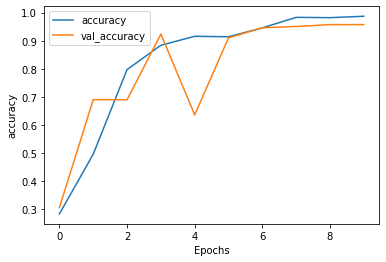

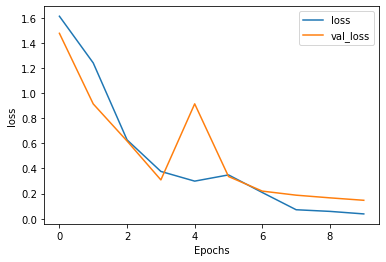

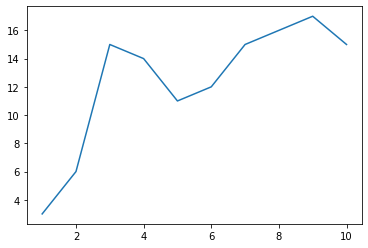

In [9]:

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

plt.plot(range(1, len(complexities)+1), complexities)
plt.savefig("/plot.png")
plt.show()